In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from helper import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pytorch_model_summary import summary

In [30]:
# read in live data
df = pd.read_csv("../data/processed/live_20.csv")

# update timestamp dtype
df = update_timestamps(df, "published")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32816 entries, 0 to 32815
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   published           32816 non-null  datetime64[ns, UTC]
 1   free                32816 non-null  float64            
 2   total               32816 non-null  float64            
 3   anteil_frei         32816 non-null  float64            
 4   auslastung          32816 non-null  float64            
 5   auslastung_prozent  32816 non-null  float64            
 6   missing             32816 non-null  float64            
 7   title               32816 non-null  object             
 8   name                32816 non-null  object             
 9   id2                 32816 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(6), object(3)
memory usage: 2.5+ MB


In [31]:
def integrate_garage(df, old, new=None, shift=1):
    if new is None:
        new = old
    df[new] = df[old] - df[old].shift(shift)
    return df

def integrate_df(df, old, new=None, shift=1):
    
    new_df = pd.DataFrame()
    df = df.copy()
    for t in set(df["title"]):
        sub_df = df.loc[df["title"]==t]
        sub_df = sub_df.sort_values("published")
        sub_df = integrate_garage(sub_df, old, new, shift)
        new_df = new_df.append(sub_df)

    return new_df

df = integrate_df(df, "free", "free [i]")
df = df.dropna()

In [32]:
df

,published,free,total,anteil_frei,auslastung,auslastung_prozent,missing,title,name,id2,free [i]
26,2022-10-20 01:00:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0.0,Parkhaus Aeschen,Aeschen,aeschen,0.000000
32,2022-10-20 01:20:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0.0,Parkhaus Aeschen,Aeschen,aeschen,0.000000
63,2022-10-20 01:40:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0.0,Parkhaus Aeschen,Aeschen,aeschen,0.000000
67,2022-10-20 02:00:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0.0,Parkhaus Aeschen,Aeschen,aeschen,0.000000
90,2022-10-20 02:20:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0.0,Parkhaus Aeschen,Aeschen,aeschen,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
32739,2022-11-17 10:40:00+00:00,254.076923,286.0,0.888381,0.111619,11.161915,0.0,Parkhaus Centralbahnparking,Centralbahnparking,centralbahnparking,-11.687783
32762,2022-11-17 11:00:00+00:00,243.153846,286.0,0.850188,0.149812,14.981173,0.0,Parkhaus Centralbahnparking,Centralbahnparking,centralbahnparking,-10.923077
32779,2022-11-17 11:20:00+00:00,231.875000,286.0,0.810752,0.189248,18.924825,0.0,Parkhaus Centralbahnparking,Centralbahnparking,centralbahnparking,-11.278846
32790,2022-11-17 11:40:00+00:00,220.588235,286.0,0.771288,0.228712,22.871246,0.0,Parkhaus Centralbahnparking,Centralbahnparking,centralbahnparking,-11.286765


## torch

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [227]:
sub_df = df.loc[df["title"]=="Parkhaus Steinen"]["free"]

In [228]:
#cnn
def sliding_window(data, seq_len):
    '''Creates a sliding window over the dataset with len 12/1 for train/test'''
    X = []
    Y = []
    
    for i in range(len(data) - seq_len-seq_len):
        x = data[i:(i+seq_len)].to_numpy()
        y = data[(i+seq_len):(i+seq_len+1)].to_numpy()
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

train_seq_len = 48
train_ratio = 0.8

def train_test_split(df, train_ratio, train_seq_len):

    len_train = int(len(df) * train_ratio)
    
    X_train, Y_train = sliding_window(df[:len_train], train_seq_len)
    X_test, Y_test = sliding_window(df[len_train:], train_seq_len)
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = train_test_split(sub_df, train_ratio, train_seq_len)

In [229]:
from torch.utils.data import Dataset

class TimeSeriesDataSet(Dataset):
    def __init__(self, sequences, labels):
        self.labels = labels
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequences = self.sequences[idx]
        sequences = torch.from_numpy(self.sequences[idx]).float()
        
        labels = self.labels[idx]
        labels = torch.from_numpy(self.labels[idx]).float()

        return sequences, labels

In [230]:
train_set = TimeSeriesDataSet(X_train, Y_train)
test_set = TimeSeriesDataSet(X_test, Y_test)

In [231]:
from torch.utils.data import DataLoader
# Set seed 
torch.manual_seed(42)
batch_size = 64

train_dataloader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=False)

In [232]:
example_batch = iter(train_dataloader)
sequences, labels = example_batch.next()
np.shape(sequences), np.shape(labels)

(torch.Size([64, 48]), torch.Size([64, 1]))

In [233]:
sequences, labels

(tensor([[146.2500, 169.8125, 188.0000,  ..., 439.7692, 437.0625, 436.9333],
         [423.7692, 425.3529, 424.0000,  ...,  13.5714,  36.2667,  56.6667],
         [430.0000, 432.1250, 434.9286,  ...,   1.8462,   0.0000,   1.2143],
         ...,
         [  8.7500,  19.3333,  36.4667,  ..., 234.6875, 198.0769, 168.7692],
         [174.4016, 158.9207, 149.8462,  ..., 326.7171, 346.2917, 363.4945],
         [430.0625, 421.3846, 404.1111,  ..., 272.1333, 308.7500, 337.6250]]),
 tensor([[436.0000],
         [ 75.8571],
         [ 16.2500],
         [  0.0000],
         [ 54.3453],
         [189.5714],
         [414.6667],
         [424.5625],
         [291.5333],
         [176.2353],
         [309.3529],
         [195.8462],
         [442.2857],
         [459.0000],
         [434.1736],
         [205.4286],
         [424.4375],
         [163.5333],
         [429.4286],
         [390.5000],
         [168.4118],
         [263.8000],
         [ 68.6154],
         [422.7143],
         [ 94.3087

In [234]:
from torch.optim import Adam
from torch.nn import MSELoss


class ModelTrainer():
    
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
        self.criterion = MSELoss(reduction='sum')
        self.score_test_last_epoch = []
        self.score_train_last_epoch = []
        self.log = dict(
            train_loss=[], 
            test_loss=[],
            train_score=[],
            test_score=[]
        )
        
    def predict(self, x, y, future=0):
        with torch.no_grad():
            labels_pred = self.model(x, future)
            loss = self.criterion(labels_pred[:,-future:].float(), y)
            y = labels_pred.detach().numpy()
            return y

    def train_model(self, train_dataloader, test_dataloader=None, num_epochs = 100):
        
        optimiser = Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(num_epochs):
            print("epoch:", epoch+1)
            len_test = 0
            len_train = 0
            train_epoch_loss = 0
            test_epoch_loss = 0
            residuals = []
            for batch, (sequences, labels) in enumerate(train_dataloader):
                sequences = sequences.to(device)
                labels = labels.to(device)

                labels_pred = self.model(sequences)
                loss = self.criterion(labels_pred.float(), labels)
                
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                len_train += len(labels)
                train_epoch_loss += loss.item()
                residuals.extend(labels_pred.cpu().detach().numpy() - labels.cpu().detach().numpy())
            if test_dataloader is not None:
                residuals_test = []
                for batch, (sequences, labels) in enumerate(test_dataloader):
                    sequences = sequences.to(device)
                    labels = labels.to(device)
                    len_test += len(labels)
                    with torch.no_grad():
                        
                        labels_pred = self.model(sequences)
                        loss = self.criterion(labels_pred.float(), labels)
                        test_epoch_loss += loss.item()
                        residuals_test.extend(labels_pred.cpu().numpy() - labels.cpu().numpy())
            self.score_test_last_epoch = residuals_test
            self.score_train_last_epoch = residuals

            self.log["train_loss"].append(train_epoch_loss)
            self.log["test_loss"].append(test_epoch_loss)
            print(train_epoch_loss, test_epoch_loss)
            rmse_sample_test = np.sqrt(test_epoch_loss/len_test)
            rmse_sample_train = np.sqrt(train_epoch_loss/len_train)
            self.log["train_score"].append(rmse_sample_train)
            self.log["test_score"].append(rmse_sample_test)
            print("rmse testset:", rmse_sample_test)
            print("rmse trainset:", rmse_sample_train)

In [298]:
import torch.nn.functional as F

class CNNForecaster(nn.Module):
    def __init__(self, kernel_size=3, pool_size=2, padding=0, conv1_channels = 120, 
                 conv2_channels=120, conv3_channels=120, fc_linear_1=180, dropout=0.5):
        '''Convolutional Net class'''
        super(CNNForecaster, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv3 = nn.Conv1d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding) 
        
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=1)
        
        self.fc1 = nn.Linear(in_features=conv3_channels*3, out_features=fc_linear_1)
        self.fc2 = nn.Linear(in_features=fc_linear_1, out_features=1)
        
        self.conv3_channels = conv3_channels
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        '''
        Applies the forward pass
        Args:
            x (torch.tensor): input feature tensor
        Returns:
            x (torch.tensor): output tensor of size num_classes
        '''
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            # nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
            # nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.Flatten(),
            # nn.Linear(4320, 180),
            # nn.ReLU(),
            # # nn.Dropout(0.5),
            # nn.BatchNorm1d(20),
            # nn.ReLU(),
            nn.Linear(1152, 1),
            # nn.Dropout(0.1)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        logits = self.network(x)
        return logits



In [302]:
model = CNN2().to(device)

trainer = ModelTrainer(model, lr=0.001)    
trainer.train_model(train_dataloader, test_dataloader, num_epochs=600)

epoch: 1
60946316.390625 4799716.6875
rmse testset: 123.63543963893757
rmse trainset: 198.67813881670284
epoch: 2
14530145.541015625 1718034.84375
rmse testset: 73.96924054615216
rmse trainset: 97.00884508112571
epoch: 3
7103170.5380859375 2104886.171875
rmse testset: 81.87465508995275
rmse trainset: 67.82697880021243
epoch: 4
6056230.595703125 860272.1328125
rmse testset: 52.342336289018235
rmse trainset: 62.62929939169661
epoch: 5
4019644.8046875 586115.4296875
rmse testset: 43.20427812944345
rmse trainset: 51.02349355177138
epoch: 6
3353981.6953125 569766.8515625
rmse testset: 42.59746604266936
rmse trainset: 46.60759527564753
epoch: 7
2673550.7431640625 445861.79296875
rmse testset: 37.682117984848524
rmse trainset: 41.612189506450704
epoch: 8
2287308.1787109375 383218.98828125
rmse testset: 34.93483416073956
rmse trainset: 38.48918308032819
epoch: 9
1871715.15625 286555.05859375
rmse testset: 30.209199393654465
rmse trainset: 34.817391471311865
epoch: 10
1829531.28515625 533508.15

In [303]:
np.std(trainer.score_test_last_epoch)


17.853142

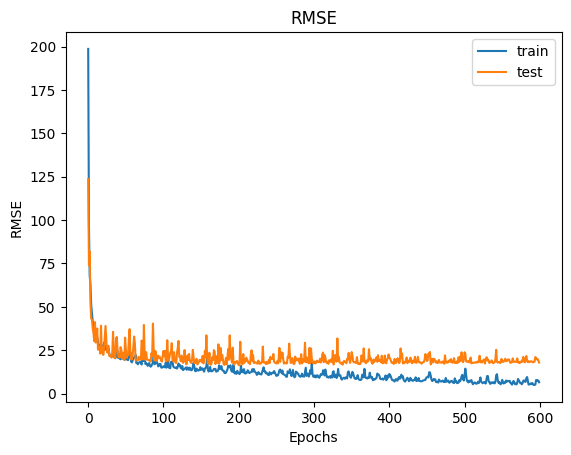

In [304]:
plt.plot(trainer.log["train_score"], label="train")
plt.plot(trainer.log["test_score"], label="test")
plt.legend()
plt.title("RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()


## Ziel für die Metrik

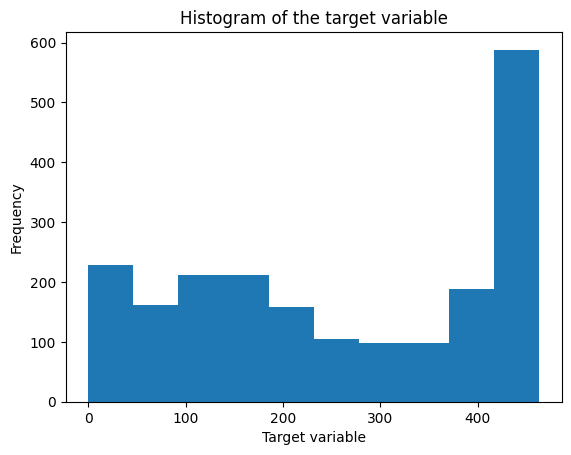

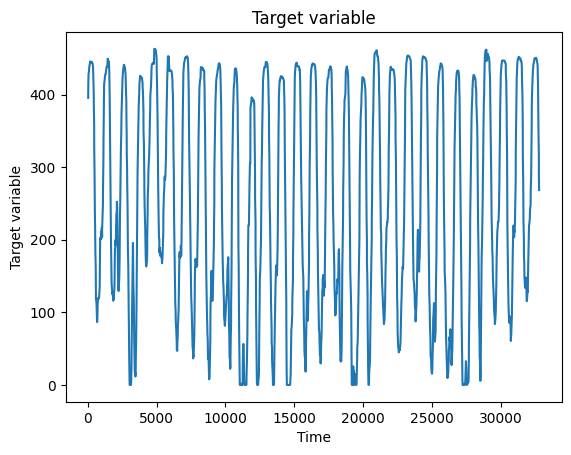

In [48]:
plt.hist(sub_df)
plt.title("Histogram of the target variable")
plt.xlabel("Target variable")
plt.ylabel("Frequency")
plt.show()

sub_df.describe()
plt.plot(sub_df)
plt.title("Target variable")
plt.xlabel("Time")
plt.ylabel("Target variable")
plt.show()

In [156]:
# plt.boxplot(sub_df)
# plt.title("Boxplot of the target variable")
# plt.xlabel("Target variable")
# plt.ylabel("Frequency")
# plt.show()

# max(sub_df)
# sub_df.values
# sub_df.groupby(sub_df.values).mean()
print('95% quantil', np.percentile(sub_df, 95))
print('max', np.max(sub_df))

95% quantil 450.0
max 463.0
